In [ ]:
!pip install transformers torch spacy scikit-learn numpy pandas tqdm matplotlib seaborn
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Risk analysis testing

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Training Random Forest model...
Evaluating model...

Classification Report:
                                                      precision    recall  f1-score   support

                               Any Other Cyber Crime       0.68      0.10      0.17      2091
Child Pornography CPChild Sexual Abuse Material CSAM       0.94      0.25      0.39        69
                                Cryptocurrency Crime       0.80      0.04      0.08        96
                      Cyber Attack/ Dependent Crimes       1.00      1.00      1.00       765
                                     Cyber Terrorism       1.00      0.03      0.06        31
      Hacking  Damage to computercomputer system etc       0.72      0.06      0.11       341
                            Online Cyber Trafficking       0.00      0.00      0.00        34
                              Online Financial Fraud       0.77      0.99      0.87     11471
                            Online Gambling  Betting       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


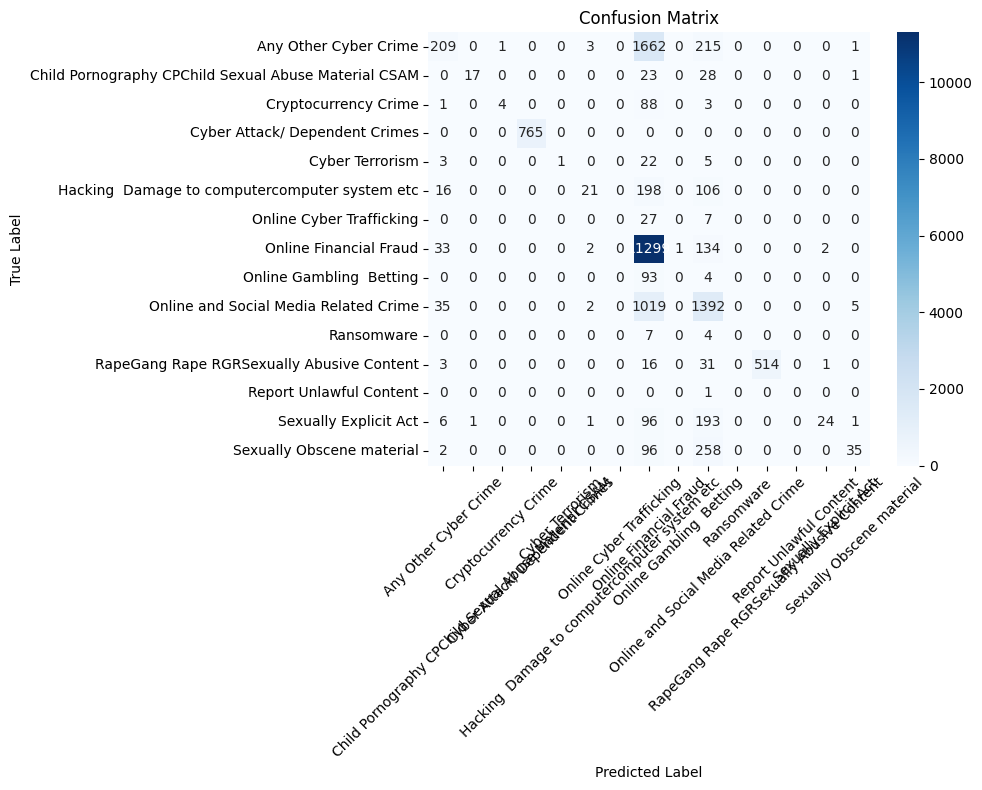


Sample text: Someone has created a fake profile with my photos
Predicted category: Online and Social Media Related Crime


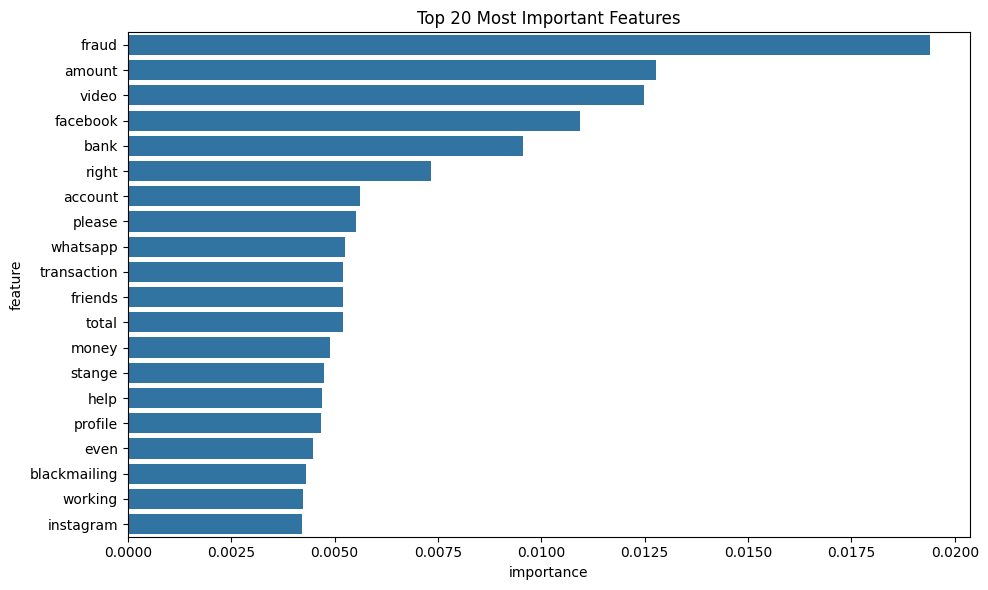

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

class CybercrimeClassifier:
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=5000)
        self.label_encoder = LabelEncoder()
        self.model = None
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        """Clean and preprocess text data"""
        # Convert to string and lowercase
        text = str(text).lower()

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords
        tokens = [t for t in tokens if t not in self.stop_words]

        return ' '.join(tokens)

    def prepare_data(self, df):
        """Prepare data for training"""
        # Preprocess text
        df['cleaned_text'] = df['crimeaditionalinfo'].apply(self.preprocess_text)

        # Encode categories
        df['category_encoded'] = self.label_encoder.fit_transform(df['category'])

        # Create TF-IDF features
        X = self.tfidf.fit_transform(df['cleaned_text'])
        y = df['category_encoded']

        return X, y

    def train_model(self, X_train, y_train, model_type='rf'):
        """Train the specified model"""
        if model_type == 'nb':
            self.model = MultinomialNB()
        elif model_type == 'lr':
            self.model = LogisticRegression(max_iter=1000)
        else:
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)

        self.model.fit(X_train, y_train)

    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance"""
        predictions = self.model.predict(X_test)

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, predictions,
                                 target_names=self.label_encoder.classes_))

        # Create confusion matrix
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def predict(self, text):
        """Predict category for new text"""
        # Preprocess the text
        cleaned_text = self.preprocess_text(text)

        # Transform using TF-IDF
        text_tfidf = self.tfidf.transform([cleaned_text])

        # Make prediction
        prediction = self.model.predict(text_tfidf)

        # Get predicted category name
        predicted_category = self.label_encoder.inverse_transform(prediction)[0]

        return predicted_category

# Main execution
def main():
    # Load your data
    # Note: Replace this with your actual data loading code
    df = pd.read_csv('train.csv')

    # Initialize classifier
    classifier = CybercrimeClassifier()

    # Prepare data
    X, y = classifier.prepare_data(df)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train model
    print("Training Random Forest model...")
    classifier.train_model(X_train, y_train, model_type='rf')

    # Evaluate model
    print("Evaluating model...")
    classifier.evaluate_model(X_test, y_test)

    # Example prediction
    sample_text = "Someone has created a fake profile with my photos"
    predicted_category = classifier.predict(sample_text)
    print(f"\nSample text: {sample_text}")
    print(f"Predicted category: {predicted_category}")

    # Feature importance analysis (for Random Forest)
    if isinstance(classifier.model, RandomForestClassifier):
        feature_importance = pd.DataFrame({
            'feature': classifier.tfidf.get_feature_names_out(),
            'importance': classifier.model.feature_importances_
        })
        feature_importance = feature_importance.sort_values(
            'importance', ascending=False
        ).head(20)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature')
        plt.title('Top 20 Most Important Features')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You shou

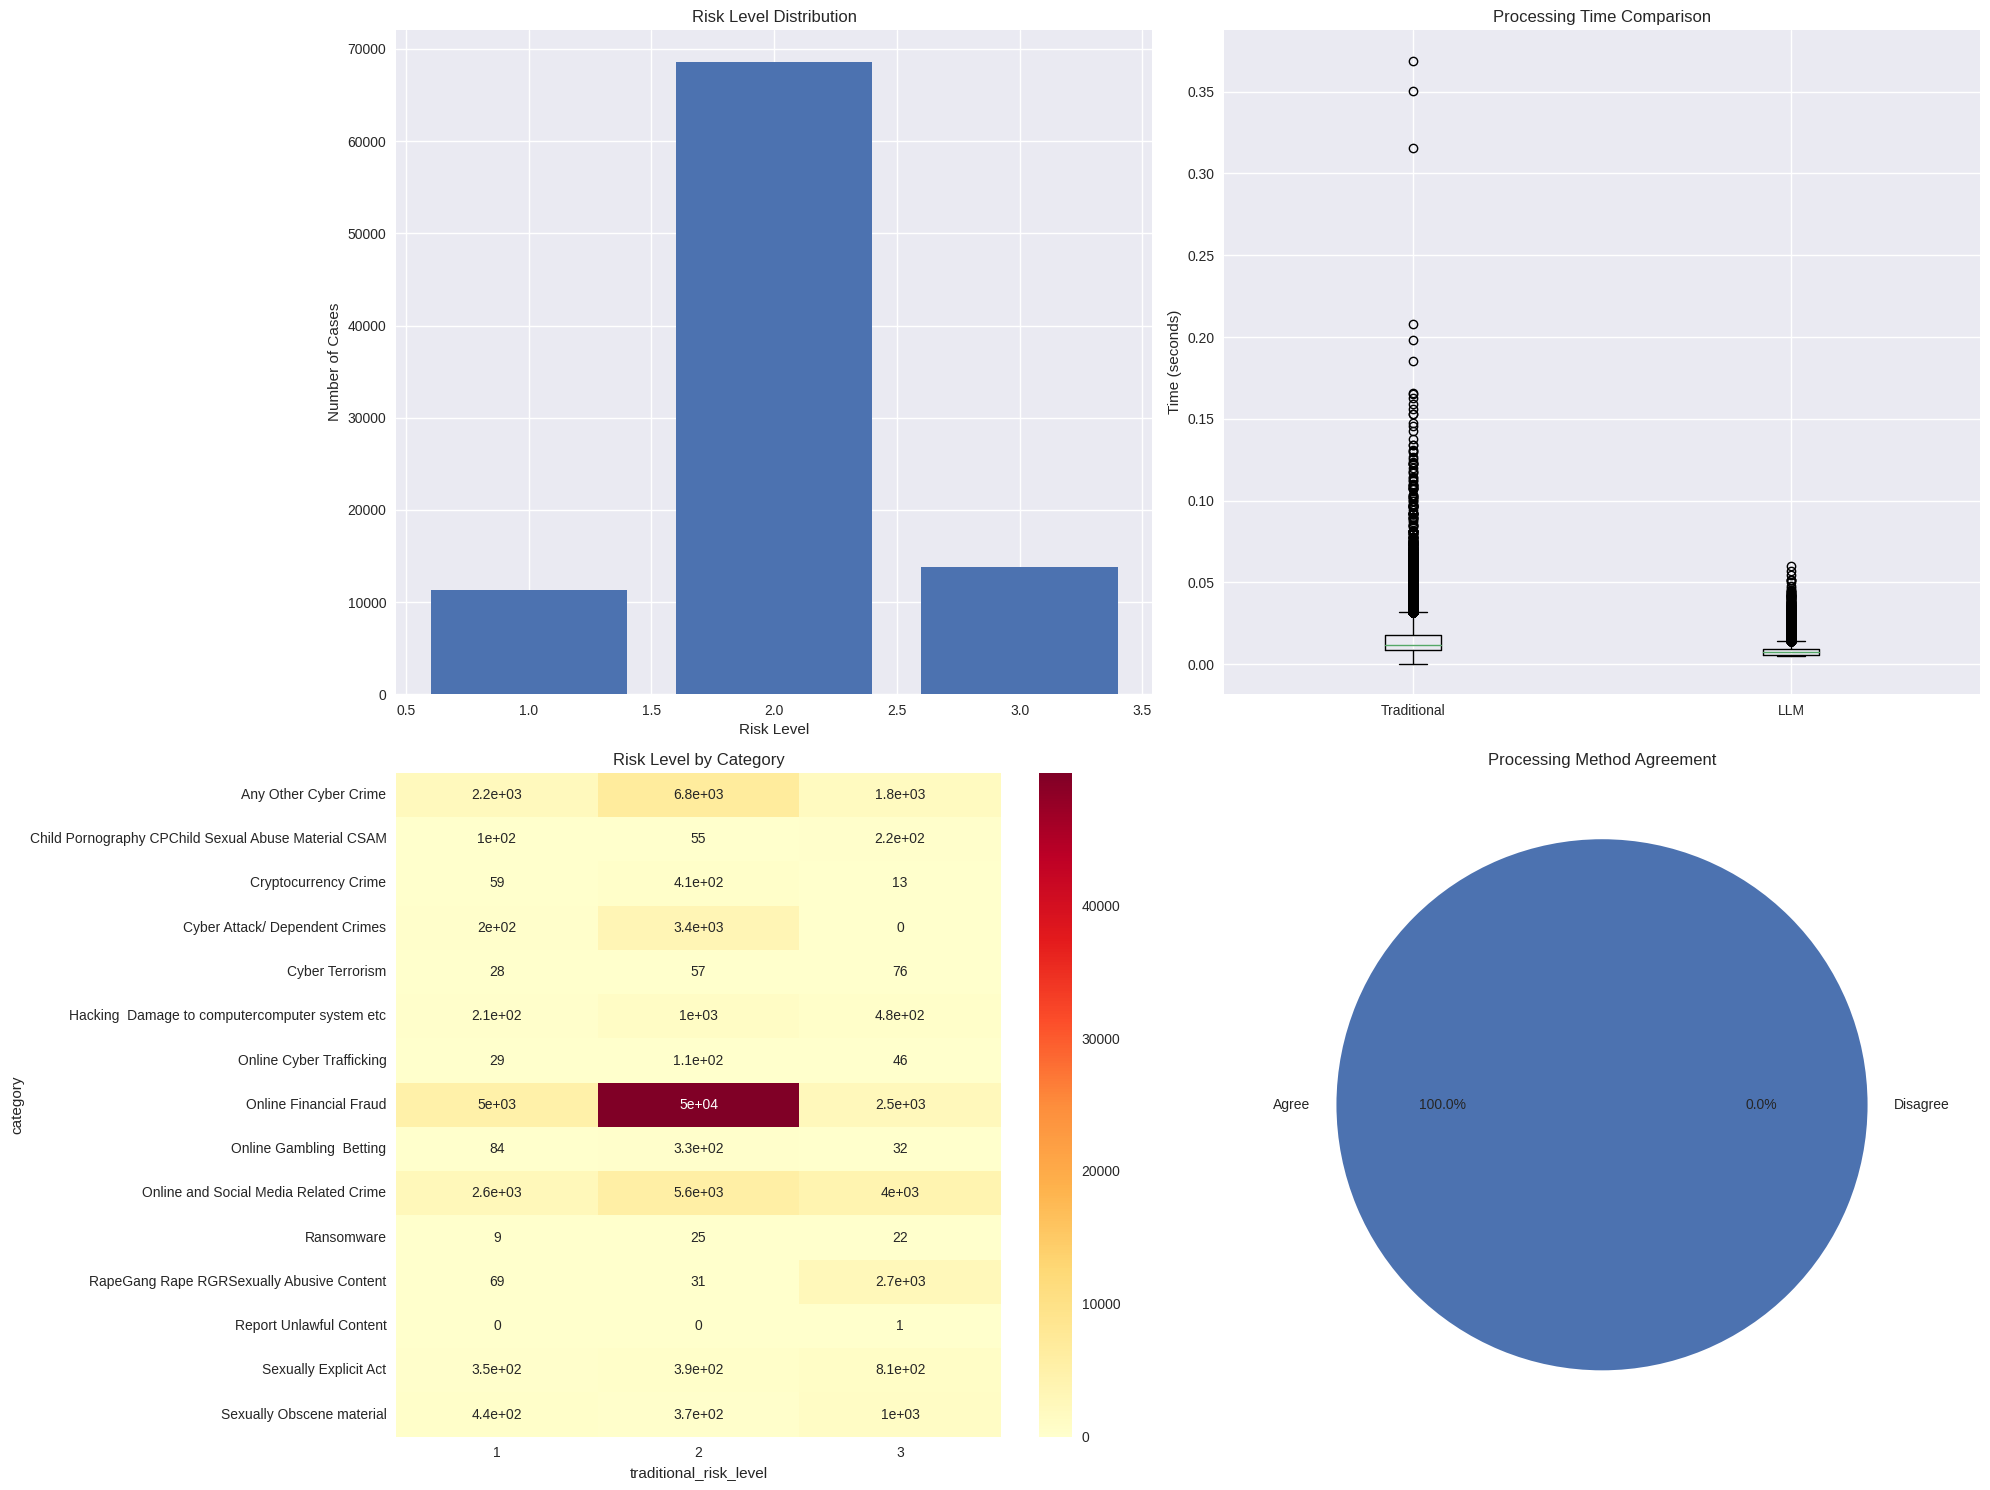

In [ ]:
# Import required packages
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import spacy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import re
from datetime import datetime
import logging
from functools import lru_cache

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class RiskAnalyzer:
    """Analyzes text and assigns risk levels"""
    def __init__(self):
        # Keywords for different risk levels
        self.risk_keywords = {
            'high_risk': [  # Level 3
                'suicide', 'kill', 'murder', 'threat', 'die', 'death',
                'minor', 'child', 'children', 'cyber bullying', 'cyberbully',
                'blackmail', 'extortion', 'abuse', 'sexual', 'rape', 'kidnap',
                'life threat', 'revenge', 'nude', 'explicit', 'torture',
                'bomb', 'attack', 'harassment', 'stalking', 'private photo',
                'physical', 'violence', 'danger', 'weapon'
            ],
            'medium_risk': [  # Level 2
                'fraud', 'scam', 'hack', 'stolen', 'theft', 'upi',
                'bank', 'credit card', 'debit card', 'money', 'payment',
                'account', 'password', 'compromise', 'cryptocurrency',
                'bitcoin', 'investment', 'otp', 'kyc', 'aadhaar',
                'pan card', 'document', 'identity theft', 'lost money',
                'unauthorized', 'transaction', 'financial'
            ],
            'low_risk': [  # Level 1
                'spam', 'advertisement', 'fake profile', 'friend request',
                'social media', 'connection', 'follow', 'unknown', 'suspicious',
                'fake account', 'wrong', 'mistake', 'error', 'help',
                'question', 'information', 'advice'
            ]
        }

    def analyze_text(self, text: str) -> Dict:
        """
        Analyze text and return risk assessment
        """
        # Handle non-string inputs
        if not isinstance(text, str):
            if pd.isna(text):
                return {
                    'risk_level': 1,
                    'reasons': ['Empty text'],
                    'description': 'Empty or null input'
                }
            text = str(text)

        text = text.lower()

        # Check for high risk keywords (Level 3)
        high_risk_matches = [word for word in self.risk_keywords['high_risk']
                           if word in text]
        if high_risk_matches:
            return {
                'risk_level': 3,
                'reasons': high_risk_matches,
                'description': 'High Risk - Immediate Attention Required'
            }

        # Check for medium risk keywords (Level 2)
        medium_risk_matches = [word for word in self.risk_keywords['medium_risk']
                             if word in text]
        if medium_risk_matches:
            return {
                'risk_level': 2,
                'reasons': medium_risk_matches,
                'description': 'Medium Risk - Priority Processing'
            }

        # Default to low risk (Level 1)
        low_risk_matches = [word for word in self.risk_keywords['low_risk']
                          if word in text]
        return {
            'risk_level': 1,
            'reasons': low_risk_matches or ['general complaint'],
            'description': 'Low Risk - Regular Processing'
        }

class TraditionalProcessor:
    """Traditional ML-based approach using spaCy"""
    def __init__(self):
        self.nlp = self.load_spacy_model()
        self.risk_analyzer = RiskAnalyzer()

    @staticmethod
    @lru_cache(maxsize=1)
    def load_spacy_model():
        """Load and cache spaCy model"""
        try:
            return spacy.load("en_core_web_sm")
        except Exception as e:
            logger.error(f"Failed to load spaCy model: {e}")
            raise

    def process_text(self, text: str) -> Dict:
        """Process text using traditional NLP approach"""
        # Handle non-string inputs
        if not isinstance(text, str):
            if pd.isna(text):
                text = ""
            else:
                text = str(text)

        start_time = time.time()

        try:
            # Process text with spaCy
            doc = self.nlp(text)

            # Extract entities
            entities = [(ent.text, ent.label_) for ent in doc.ents]

            # Get risk assessment
            risk_assessment = self.risk_analyzer.analyze_text(text)

            return {
                'entities': entities,
                'risk_assessment': risk_assessment,
                'processing_time': time.time() - start_time,
                'method': 'traditional'
            }
        except Exception as e:
            logger.error(f"Error processing text with traditional approach: {e}")
            return {
                'entities': [],
                'risk_assessment': {
                    'risk_level': 1,
                    'reasons': ['Processing error'],
                    'description': 'Error during processing'
                },
                'processing_time': time.time() - start_time,
                'method': 'traditional'
            }

class LLMProcessor:
    """LLM-based approach using DistilBERT"""
    def __init__(self):
        try:
            self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
            self.model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
            self.risk_analyzer = RiskAnalyzer()

            # Move to GPU if available
            if torch.cuda.is_available():
                self.model = self.model.to('cuda')
        except Exception as e:
            logger.error(f"Failed to initialize LLM processor: {e}")
            raise

    def process_text(self, text: str) -> Dict:
        """Process text using LLM approach"""
        # Handle non-string inputs
        if not isinstance(text, str):
            if pd.isna(text):
                text = ""
            else:
                text = str(text)

        start_time = time.time()

        try:
            # Tokenize and process with LLM
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            if torch.cuda.is_available():
                inputs = inputs.to('cuda')

            with torch.no_grad():
                outputs = self.model(**inputs)

            # Get risk assessment
            risk_assessment = self.risk_analyzer.analyze_text(text)

            return {
                'embeddings': outputs.logits.cpu().numpy(),
                'risk_assessment': risk_assessment,
                'processing_time': time.time() - start_time,
                'method': 'llm'
            }
        except Exception as e:
            logger.error(f"Error processing text with LLM approach: {e}")
            return {
                'embeddings': np.zeros((1, self.model.config.hidden_size)),
                'risk_assessment': {
                    'risk_level': 1,
                    'reasons': ['Processing error'],
                    'description': 'Error during processing'
                },
                'processing_time': time.time() - start_time,
                'method': 'llm'
            }

class CybercrimeAnalysisSystem:
    """Main system combining both traditional and LLM approaches"""
    def __init__(self):
        self.traditional_processor = TraditionalProcessor()
        self.llm_processor = LLMProcessor()
        self.use_gpu = torch.cuda.is_available()

    def process_dataset(self, df: pd.DataFrame, batch_size: int = 32) -> pd.DataFrame:
        """Process entire dataset with both approaches"""
        results = []

        # Clean the input data
        df['crimeaditionalinfo'] = df['crimeaditionalinfo'].fillna("")
        df['crimeaditionalinfo'] = df['crimeaditionalinfo'].astype(str)

        # Process in batches
        for start_idx in tqdm(range(0, len(df), batch_size)):
            batch_df = df.iloc[start_idx:start_idx + batch_size]

            for idx, row in batch_df.iterrows():
                text = row['crimeaditionalinfo']

                try:
                    # Process with both approaches
                    trad_result = self.traditional_processor.process_text(text)
                    llm_result = self.llm_processor.process_text(text)

                    # Combine results
                    result = {
                        'text': text,
                        'category': row['category'],
                        'sub_category': row['sub_category'],
                        'traditional_risk_level': trad_result['risk_assessment']['risk_level'],
                        'llm_risk_level': llm_result['risk_assessment']['risk_level'],
                        'traditional_processing_time': trad_result['processing_time'],
                        'llm_processing_time': llm_result['processing_time'],
                        'risk_reasons': trad_result['risk_assessment']['reasons'],
                        'risk_description': trad_result['risk_assessment']['description']
                    }

                    results.append(result)
                except Exception as e:
                    logger.error(f"Error processing row {idx}: {e}")
                    results.append({
                        'text': text,
                        'category': row['category'],
                        'sub_category': row['sub_category'],
                        'traditional_risk_level': 1,
                        'llm_risk_level': 1,
                        'traditional_processing_time': 0,
                        'llm_processing_time': 0,
                        'risk_reasons': ['Processing error'],
                        'risk_description': 'Error during processing'
                    })

        return pd.DataFrame(results)

def visualize_results(df: pd.DataFrame) -> None:
    """Create visualizations for analysis results"""
    if df.empty:
        logger.warning("Cannot create visualizations: DataFrame is empty")
        return

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(20, 15))

    # 1. Risk Level Distribution
    plt.subplot(2, 2, 1)
    risk_dist = df['traditional_risk_level'].value_counts().sort_index()
    plt.bar(risk_dist.index, risk_dist.values)
    plt.title('Risk Level Distribution')
    plt.xlabel('Risk Level')
    plt.ylabel('Number of Cases')

    # 2. Processing Time Comparison
    plt.subplot(2, 2, 2)
    times_data = {
        'Traditional': df['traditional_processing_time'],
        'LLM': df['llm_processing_time']
    }
    plt.boxplot([times_data['Traditional'], times_data['LLM']], labels=['Traditional', 'LLM'])
    plt.title('Processing Time Comparison')
    plt.ylabel('Time (seconds)')

    # 3. Risk Level by Category
    plt.subplot(2, 2, 3)
    risk_cat = pd.crosstab(df['category'], df['traditional_risk_level'])
    sns.heatmap(risk_cat, annot=True, cmap='YlOrRd')
    plt.title('Risk Level by Category')

    # 4. Processing Method Agreement
    plt.subplot(2, 2, 4)
    agreement = (df['traditional_risk_level'] == df['llm_risk_level']).mean() * 100
    plt.pie([agreement, 100-agreement], labels=['Agree', 'Disagree'], autopct='%1.1f%%')
    plt.title('Processing Method Agreement')

    plt.tight_layout()
    plt.show()

def main():
    try:
        # Load datasets
        logger.info("Loading datasets...")
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')

        # Initialize system
        logger.info("Initializing system...")
        system = CybercrimeAnalysisSystem()

        # Process training data
        logger.info("Processing training data...")
        train_results = system.process_dataset(train_df)

        # Process test data
        logger.info("Processing test data...")
        test_results = system.process_dataset(test_df)

        # Visualize results
        logger.info("Generating visualizations...")
        visualize_results(train_results)

        # Save processed data
        train_results.to_csv('train_processed.csv', index=False)
        test_results.to_csv('test_processed.csv', index=False)

        # Print summary statistics
        logger.info("\nSummary Statistics:")
        logger.info("-" * 50)
        logger.info(f"Total cases processed: {len(train_results) + len(test_results)}")
        logger.info("\nRisk Level Distribution (Training Data):")
        logger.info(train_results['traditional_risk_level'].value_counts().sort_index())
        logger.info("\nAverage Processing Times:")
        logger.info(f"Traditional: {train_results['traditional_processing_time'].mean():.4f} seconds")
        logger.info(f"LLM: {train_results['llm_processing_time'].mean():.4f} seconds")

    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        raise

if __name__ == "__main__":
    main()

In [ ]:
# Install required packages
!pip install nltk pandas numpy scikit-learn spacy tqdm
!python -m spacy download en_core_web_sm

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import re
import string
import spacy
import warnings
import json
from tqdm import tqdm
from datetime import datetime
import os

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directories
!mkdir -p /content/drive/MyDrive/cybercrime_project
!mkdir -p /content/drive/MyDrive/cybercrime_project/models
!mkdir -p /content/drive/MyDrive/cybercrime_project/data
!mkdir -p /content/drive/MyDrive/cybercrime_project/predictions

print("Setup completed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/drive
Setup completed successfully!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel, BertTokenizerFast
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
import logging
import json
from sklearn.preprocessing import LabelEncoder

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class CybercrimeDataset(Dataset):
    """Custom Dataset for Cybercrime text data"""
    def __init__(self, texts, categories, subcategories, tokenizer, max_length=512):
        self.texts = texts
        self.categories = categories
        self.subcategories = subcategories
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'category': torch.tensor(self.categories[idx], dtype=torch.long),
            'subcategory': torch.tensor(self.subcategories[idx], dtype=torch.long)
        }

class CybercrimeClassifier(nn.Module):
    """BERT-based model for cybercrime classification"""
    def __init__(self, n_categories, n_subcategories, pretrained_model="bert-base-uncased"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.3)

        # Hidden layers
        self.hidden = nn.Linear(self.bert.config.hidden_size, 256)
        self.activation = nn.ReLU()

        # Output layers
        self.category_classifier = nn.Linear(256, n_categories)
        self.subcategory_classifier = nn.Linear(256, n_subcategories)

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        # Apply dropout and hidden layer
        x = self.dropout(pooled_output)
        x = self.hidden(x)
        x = self.activation(x)
        x = self.dropout(x)

        # Get predictions
        category_output = self.category_classifier(x)
        subcategory_output = self.subcategory_classifier(x)

        return category_output, subcategory_output

class CybercrimeNLP:
    def __init__(self, device=None):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        self.label_encoders = {
            'category': LabelEncoder(),
            'subcategory': LabelEncoder()
        }
        self.model = None
        logger.info(f"Using device: {self.device}")

    def prepare_data(self, df, batch_size=16):
        """Prepare data for training/inference"""
        # Encode labels
        categories_encoded = self.label_encoders['category'].fit_transform(df['category'])
        subcategories_encoded = self.label_encoders['subcategory'].fit_transform(df['sub_category'])

        # Create dataset
        dataset = CybercrimeDataset(
            texts=df['crimeaditionalinfo'].values,
            categories=categories_encoded,
            subcategories=subcategories_encoded,
            tokenizer=self.tokenizer
        )

        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def train(self, train_df, valid_df=None, epochs=10, batch_size=16, learning_rate=2e-5):
        """Train the model"""
        # Prepare data
        train_loader = self.prepare_data(train_df, batch_size)
        if valid_df is not None:
            valid_loader = self.prepare_data(valid_df, batch_size)

        # Initialize model
        n_categories = len(self.label_encoders['category'].classes_)
        n_subcategories = len(self.label_encoders['subcategory'].classes_)

        self.model = CybercrimeClassifier(n_categories, n_subcategories)
        self.model.to(self.device)

        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)

        # Training loop
        logger.info("Starting training...")
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')

            for batch in progress_bar:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                category_labels = batch['category'].to(self.device)
                subcategory_labels = batch['subcategory'].to(self.device)

                # Forward pass
                optimizer.zero_grad()
                category_output, subcategory_output = self.model(input_ids, attention_mask)

                # Calculate loss
                loss_category = criterion(category_output, category_labels)
                loss_subcategory = criterion(subcategory_output, subcategory_labels)
                loss = loss_category + loss_subcategory

                # Backward pass
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                progress_bar.set_postfix({'loss': total_loss / (progress_bar.n + 1)})

            # Validation
            if valid_df is not None:
                self.evaluate(valid_loader)

    def evaluate(self, val_loader):
        """Evaluate the model"""
        self.model.eval()
        total_loss = 0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                category_labels = batch['category'].to(self.device)
                subcategory_labels = batch['subcategory'].to(self.device)

                category_output, subcategory_output = self.model(input_ids, attention_mask)

                loss_category = criterion(category_output, category_labels)
                loss_subcategory = criterion(subcategory_output, subcategory_labels)
                loss = loss_category + loss_subcategory

                total_loss += loss.item()

        avg_loss = total_loss / len(val_loader)
        logger.info(f"Validation Loss: {avg_loss:.4f}")
        return avg_loss

    def predict(self, text):
        """Make predictions for new text"""
        self.model.eval()

        # Tokenize input
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Move to device
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        # Get predictions
        with torch.no_grad():
            category_output, subcategory_output = self.model(input_ids, attention_mask)

            # Get probabilities
            category_probs = torch.softmax(category_output, dim=1)
            subcategory_probs = torch.softmax(subcategory_output, dim=1)

            # Get predicted classes
            category_pred = category_output.argmax(dim=1).cpu().numpy()
            subcategory_pred = subcategory_output.argmax(dim=1).cpu().numpy()

        # Convert predictions to labels
        result = {
            'category': self.label_encoders['category'].inverse_transform(category_pred)[0],
            'subcategory': self.label_encoders['subcategory'].inverse_transform(subcategory_pred)[0],
            'confidence': {
                'category': float(category_probs.max().cpu().numpy()),
                'subcategory': float(subcategory_probs.max().cpu().numpy())
            }
        }

        return result

    def save_model(self, path):
        """Save the model and label encoders"""
        model_data = {
            'model_state': self.model.state_dict(),
            'category_classes': self.label_encoders['category'].classes_.tolist(),
            'subcategory_classes': self.label_encoders['subcategory'].classes_.tolist()
        }
        torch.save(model_data, path)
        logger.info(f"Model saved to {path}")

    def load_model(self, path):
        """Load the model and label encoders"""
        model_data = torch.load(path)

        # Load label encoder classes
        self.label_encoders['category'].classes_ = np.array(model_data['category_classes'])
        self.label_encoders['subcategory'].classes_ = np.array(model_data['subcategory_classes'])

        # Initialize and load model
        n_categories = len(self.label_encoders['category'].classes_)
        n_subcategories = len(self.label_encoders['subcategory'].classes_)
        self.model = CybercrimeClassifier(n_categories, n_subcategories)
        self.model.load_state_dict(model_data['model_state'])
        self.model.to(self.device)
        self.model.eval()

        logger.info("Model loaded successfully")

def main():
    # Load data
    train_df = pd.read_csv('/content/train.csv')
    test_df = pd.read_csv('/content/test.csv')

    # Initialize classifier
    classifier = CybercrimeNLP()

    # Split data
    train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)

    # Train model
    classifier.train(train_data, valid_data, epochs=5)

    # Save model
    classifier.save_model('cybercrime_nlp_model.pt')

    # Test predictions
    test_text = """I received a call from an unknown number claiming to be from my bank.
                   They asked for my credit card details and OTP. Later I found unauthorized transactions."""

    prediction = classifier.predict(test_text)
    print("\nSample Prediction:")
    print(json.dumps(prediction, indent=2))

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/5:  32%|███▏      | 1478/4685 [35:55<1:18:10,  1.46s/it, loss=2.87]